In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
from pathlib import Path
os.chdir("/content/drive/My Drive/Akarshan/BERT")
!ls -l

total 51436
-rw------- 1 root root  8388432 Dec 26 21:48  BERT5.hdf5
drwx------ 2 root root     4096 Dec  3 16:27  clr
-rw------- 1 root root   488019 Dec 26 22:59  Compare.ipynb
-rw------- 1 root root   459928 Dec 26 23:02 'Copy of EDA on results.ipynb'
drwx------ 2 root root     4096 Dec  3 16:27  Data
-rw------- 1 root root  8306584 Dec 24 07:57  DBert1hk.hdf5
-rw------- 1 root root 12719136 Dec 24 07:57  DBert4hk.hdf5
-rw------- 1 root root   251029 Dec 26 22:52  Distllbert400000.ipynb
-rw------- 1 root root   476324 Dec 26 22:54 'EDA on results.ipynb'
drwx------ 2 root root     4096 Dec 18 07:14 'misc model'
-rw------- 1 root root    42964 Dec 26 22:44  model.png
drwx------ 2 root root     4096 Dec  3 16:27  papers
-rw------- 1 root root  8306584 Dec 19 08:56  Rbert4.hdf5
-rw------- 1 root root   203164 Dec 26 21:29  Retraining.ipynb
-rw------- 1 root root    85578 Dec 26 22:54  Roberta.ipynb
-rw------- 1 root root 12719160 Dec 25 10:35  SBert.hdf5
-rw------- 1 root root   203468 

In [ ]:
!pip install transformers
!pip install pympler
!pip install tensorflow_addons

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 44.3 MB/s 
     |████████████████████████████████| 895 kB 38.7 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 61 kB 443 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 164 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
import numpy as np
import pickle
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from pympler import asizeof
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import pipeline
from tensorflow.keras.layers import concatenate
from transformers import TFAutoModel, AutoTokenizer, AutoConfig,TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import ModelCheckpoint
from clr import clr_callback
import tensorflow_addons as tfa

In [ ]:
csvfile = 'Data//data.csv'
dropna = 'Data//datadropna.csv'
sent_data_file = 'Data//sent_data.csv'
label_file = 'Data//label.csv'
vocab_file = 'Data//vocab_tr_w.txt'

In [ ]:
df = pd.read_csv(dropna,usecols = ['SBE','Label'])
# df.dropna(inplace=True)
print(df.head())
print(df.shape)

   Label                                                SBE
0      1  To facilitate an easier notation throughout th...
1      0  Therefore _MATH_ defines a special order of ti...
2      0  This is important since only _MATH_ is the rea...
3      0  Note that in all contour time-integrals we ess...
4      0  Theorem _REF_ proves the equivalence of ensemb...
(1189321, 2)


Working with distillbert400k as it performed the best

In [ ]:
num = len(os.listdir('Data//embeddingBr//'))

with open('Data//embeddingBr//embeddings'+str(0),'rb') as f:
    dataD = pickle.load(f)
    
for idx in range(1,num):
    
  with open('Data//embeddingBr//embeddings'+str(idx),'rb') as f:
    mat = pickle.load(f)
    dataD=np.concatenate([dataD,mat],axis=0)

In [ ]:
np.shape(dataD)

(400000, 768)

In [ ]:
df =  df.iloc[:np.shape(dataD)[0],:]

Not shuffling data for further analysis.

In [ ]:
_, temp_text, _, temp_labels = train_test_split(dataD, df['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Label'])

# we will use temp_text and temp_labels to create validation and test set
_, test_text, _, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)



test_labels = tf.keras.utils.to_categorical(test_labels)

test_data = tf.data.Dataset.from_tensor_slices((test_text))
test_data = test_data.batch(128)#no shuffle


In [ ]:
from keras.models import load_model
model = load_model("BERT5.hdf5")

In [ ]:
y_pr_ts_all = model.predict(test_data)

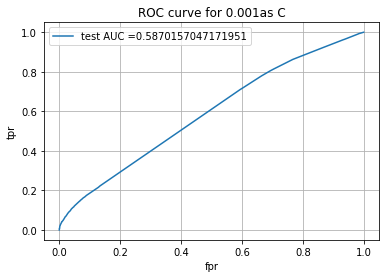

In [ ]:
y_pr_ts = y_pr_ts_all[:,0]
y_ts = test_labels[:,0]
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

test_fpr, test_tpr, te_thresholds = roc_curve(y_ts, y_pr_ts)
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

test
the maximum value of tpr*(1-fpr) 0.2901352933913039 for threshold 0.72


Test Confusion Matrix


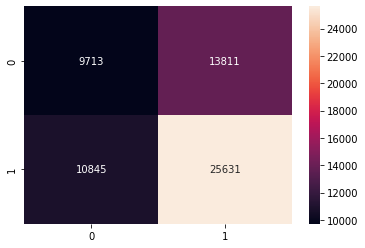

In [ ]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 58.91%
Precision on test set: 64.98%
recall score on test set: 70.27%
f1 score on test set: 67.52%


#### Clarification on FP and FN
1. After the step ***test_labels = tf.keras.utils.to_categorical(test_labels)***, Test_labels[0] stores values as follows:
0 for 'Editing Needed'
1 for 'Editing Not Needed'.
2. So TP are values which did not need editing and got classified as that(1,1).
3. TN are values which needed editing and got classified as that(0,0).
4. FP are values which needed editing but got classified otherwise(0,1).
5. FN are values which did not need editing but got classified otherwise(1,0).


In [ ]:
# with open('Data//y_pr_ts','wb') as f:
#   pickle.dump(y_pr_ts,f)
with open('Data//y_pr_ts','rb') as f:
  y_pr_ts = pickle.load(f)
# with open('Data//Preds','wb') as f:
#   pickle.dump(predict_with_best_t(y_pr_ts, best_ts_thres),f)
with open('Data//Preds','rb') as f:
  preds = pickle.load(f)
# with open('Data//y_ts','wb') as f:
#   pickle.dump(y_ts,f)
with open('Data//y_ts','rb') as f:
  y_ts = pickle.load(f)

In [ ]:
df1 = pd.read_csv('Data//data2.csv')
print(df1.shape)
df1.dropna(subset=['SBE', 'Label'],inplace=True)
print(df1.shape)
df1 = df1.iloc[:400000,:]
df1.columns

(1189412, 7)
(1189321, 7)


Index(['SID', 'Domain', 'SBE', 'SAE', 'del_word', 'ins_word', 'Label'], dtype='object')

In [ ]:
df1.shape

(400000, 7)

In [ ]:
_, temp_text, _, temp_labels = train_test_split(df1[['Domain', 'SBE', 'SAE', 'del_word', 'ins_word']], df1['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df1['Label'])

# we will use temp_text and temp_labels to create validation and test set
_, test_text1, _, test_labels1 = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)
test_labels = tf.keras.utils.to_categorical(test_labels1)

##Analysing False Positive

In [ ]:
index = []
for i,(l,p) in enumerate(zip(y_ts,preds)):
  if l == 0 and p ==1:
    index.append(i)


In [ ]:
cm = pd.DataFrame(confusion_matrix(y_ts, preds), range(2),range(2))
cm

,0,1
0,9713,13811
1,10845,25631


In [ ]:
cm.iloc[0,1]==len(index)

True

In [ ]:
fp = test_text1.iloc[index]

In [ ]:
fplabels = np.take(test_labelsf[:,0],index)

In [ ]:
np.unique(fplabels)

array([0.], dtype=float32)

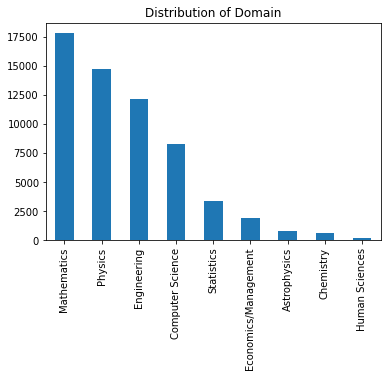

In [ ]:
plt.title('Distribution of Domain')
test_text1['Domain'].value_counts().plot(kind='bar')

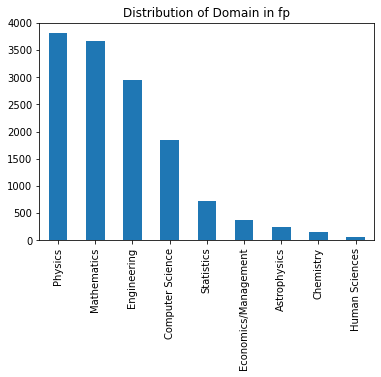

In [ ]:
plt.title('Distribution of Domain in fp')
fp['Domain'].value_counts().plot(kind='bar')

In [ ]:
del_ins_pair = fp['del_word']+' '+fp['ins_word']

In [ ]:
del_ins_pair_plt = del_ins_pair.value_counts().sort_values(ascending = False).head(30)

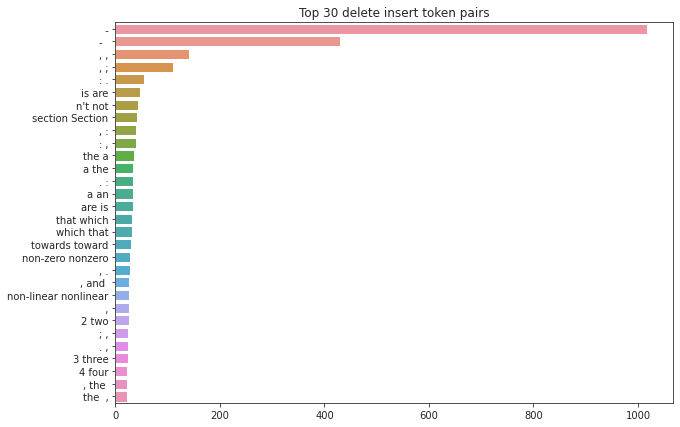

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('ticks')
plt.title('Top 30 delete insert token pairs')
sns.barplot(y=del_ins_pair_plt.index, x= del_ins_pair_plt.values )

##Analyzing FN

In [ ]:
index = []
for i,(l,p) in enumerate(zip(y_ts,preds)):
  if l == 1 and p ==0:
    index.append(i)


In [ ]:
cm.iloc[1,0]==len(index)

True

In [ ]:
fn = test_text1.iloc[index]

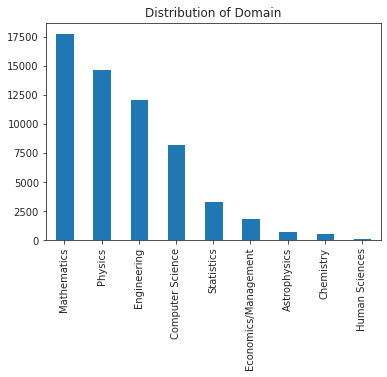

In [ ]:
plt.title('Distribution of Domain')
test_text1['Domain'].value_counts().plot(kind='bar')

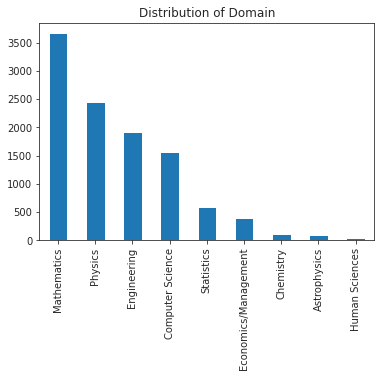

In [ ]:
plt.title('Distribution of Domain')
fn['Domain'].value_counts().plot(kind='bar')

In [ ]:
delw = fn['del_word'].value_counts().sort_values(ascending = False).head(30)

In [ ]:
delw

Series([], Name: del_word, dtype: int64)

In [ ]:
insw = fn['ins_word'].value_counts().sort_values(ascending = False).head(30)

In [ ]:
insw

Series([], Name: ins_word, dtype: int64)

##Analysing True Negatives

In [ ]:
index = []
for i,(l,p) in enumerate(zip(y_ts,preds)):
  if l == 0 and p ==0:
    index.append(i)

In [ ]:
cm.iloc[0,0]==len(index)

True

In [ ]:
tn = test_text1.iloc[index]

In [ ]:
tnlabels = np.take(test_labelsf[:,0],index)

In [ ]:
np.unique(tnlabels)

array([0.], dtype=float32)

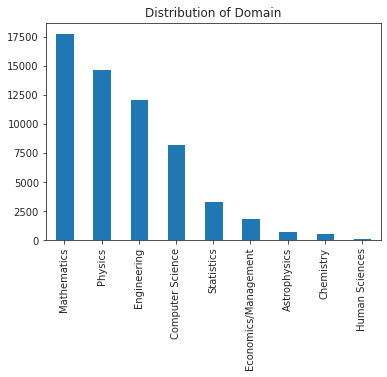

In [ ]:
plt.title('Distribution of Domain')
test_text1['Domain'].value_counts().plot(kind='bar')

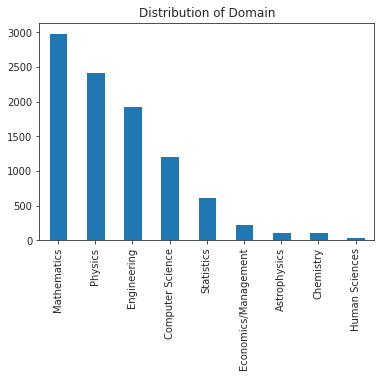

In [ ]:
plt.title('Distribution of Domain')
tn['Domain'].value_counts().plot(kind='bar')

In [ ]:
del_ins_pair = tn['del_word']+' '+tn['ins_word']

In [ ]:
del_ins_pair_plt = del_ins_pair.value_counts().sort_values(ascending = False).head(30)

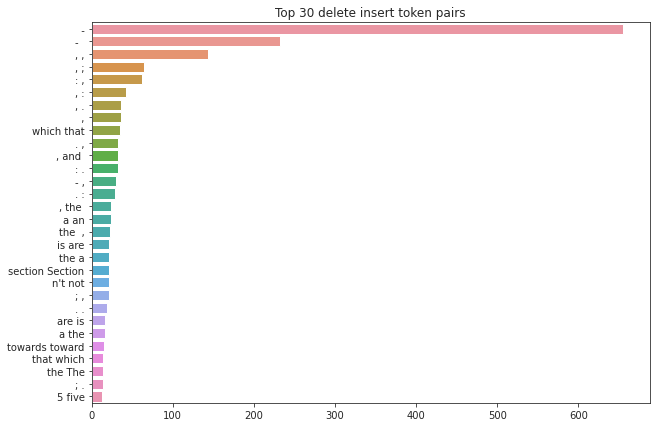

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('ticks')
plt.title('Top 30 delete insert token pairs')
sns.barplot(y=del_ins_pair_plt.index, x= del_ins_pair_plt.values )

##Error analysis

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

loss = []
for (l,p) in zip(y_ts,y_pr_ts):
  value = binary_crossentropy(tf.constant([l]), tf.constant([p]))
  loss.append(value)

loss = np.array(loss)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


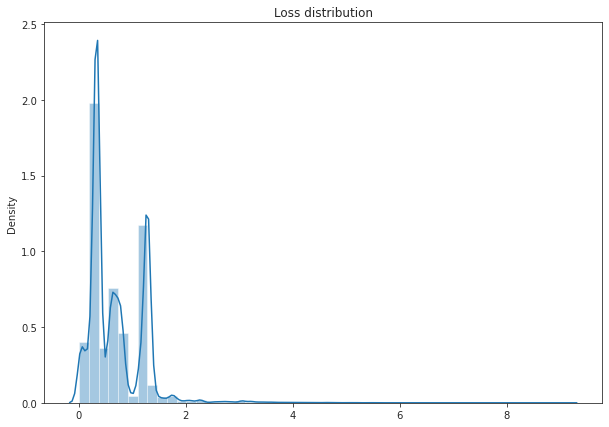

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('ticks')
plt.title('Loss distribution')
sns.distplot(loss)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


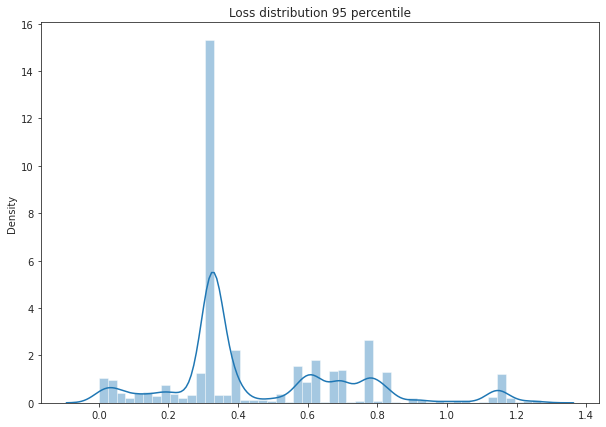

In [ ]:
thres = np.percentile(loss,90)
plotl = [l for l in loss if l<thres]

plt.figure(figsize=(10,7))
sns.set_style('ticks')
plt.title('Loss distribution 95 percentile')
sns.distplot(plotl)

[Text(0, 0.5, 'Loss IQR range')]

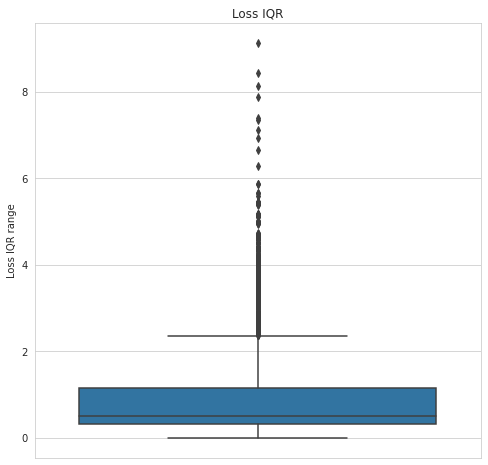

In [ ]:
plt.figure(figsize=(8,8))
sns.set_style('whitegrid')
plt.title('Loss IQR')
sns.boxplot(y= loss).set(ylabel ='Loss IQR range')

[Text(0, 0.5, 'Loss IQR range')]

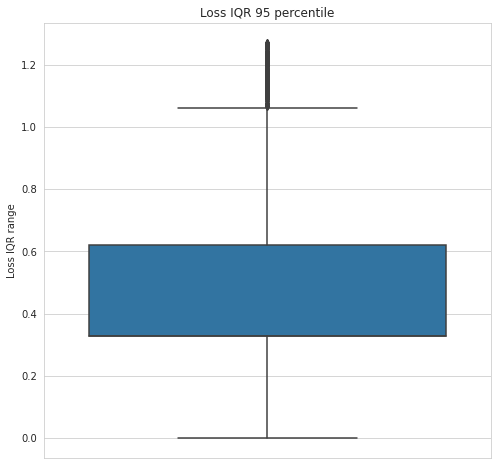

In [ ]:
thres = np.percentile(loss,90)
plotl = [l for l in loss if l<thres]

plt.figure(figsize=(8,8))
sns.set_style('whitegrid')
plt.title('Loss IQR 95 percentile')
sns.boxplot(y= plotl).set(ylabel ='Loss IQR range')

#Most Erroneous points

In [ ]:
#getting most errornous points
thres = np.percentile(loss,90)
index = [i for i,value in enumerate(loss)  if value>=thres]

In [ ]:
#Plotting confution matrix with most errornous points
erryts = np.take(y_ts,index)
errpreds = np.take(preds,index)
cm = pd.DataFrame(confusion_matrix(erryts, errpreds), range(2),range(2))
cm

,0,1
0,0,13811
1,59,0


Most of the high erroneous points are from False Positive values i.e. the texts that need editing but are classified as otherwise. 

In [ ]:
errpoints = test_text1.iloc[index]

In [ ]:
del_ins_pair = errpoints['del_word']+' '+errpoints['ins_word']

In [ ]:
del_ins_pair_plt = del_ins_pair.value_counts().sort_values(ascending = False).head(30)

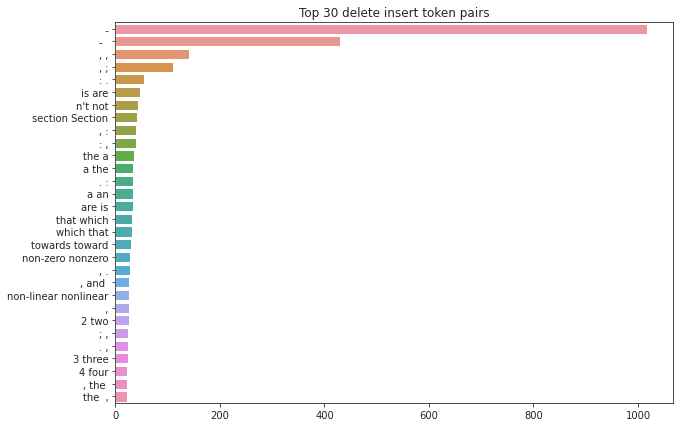

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('ticks')
plt.title('Top 30 delete insert token pairs')
sns.barplot(y=del_ins_pair_plt.index, x= del_ins_pair_plt.values )

In [ ]:
errpoints[['SBE','SAE','del_word','ins_word']]

,SBE,SAE,del_word,ins_word
202753,"The corresponding values are _MATH_ (Sept. 5, ...","The corresponding values are _MATH_ (Sept. 5, ...",Sept.,September
120881,"Consequently, by taking the average of Stokes ...","Consequently, by taking the average of Stokes ...",as small as,NaN
274647,High ILP register requirements has direct impa...,High ILP register requirements have a direct i...,in,on
88330,"On the other hand, due to _REF_, _MATH_ satisf...","On the other hand, due to _REF_, _MATH_ also s...",satisfies,satisfies
77630,If the nonzero _MATH_ is entirely generated by...,If the non-zero _MATH_ is entirely generated b...,nonzero,non-zero
...,...,...,...,...
64794,The comparison is shown in Table _REF_,A comparison is shown in Table _REF_.,The,.
223317,"In 1998 _CITE_, it is known that our universe ...","In 1998 _CITE_, it became known that our unive...",is,became
342236,This makes it possible that more performance r...,This makes it possible for more performance re...,could,to
384417,"Thus, such an accumulation generates a fund fr...","Thus, such an accumulation generates a fund fr...",NaN,","


#Least Errorenous points

In [ ]:
#getting most errornous points
thres = np.percentile(loss,40)
index = [i for i,value in enumerate(loss)  if value<=thres]

In [ ]:
#Plotting confution matrix with most errornous points
erryts = np.take(y_ts,index)
errpreds = np.take(preds,index)
cm = pd.DataFrame(confusion_matrix(erryts, errpreds), range(2),range(2))
cm

,0,1
0,105,0
1,0,25629


In [ ]:
errpoints = test_text1.iloc[index]

In [ ]:
del_ins_pair = errpoints['del_word'].fillna(' ')+' '+errpoints['ins_word'].fillna(' ')

In [ ]:
del_ins_pair_plt = del_ins_pair.value_counts().sort_values(ascending = False).head(30)

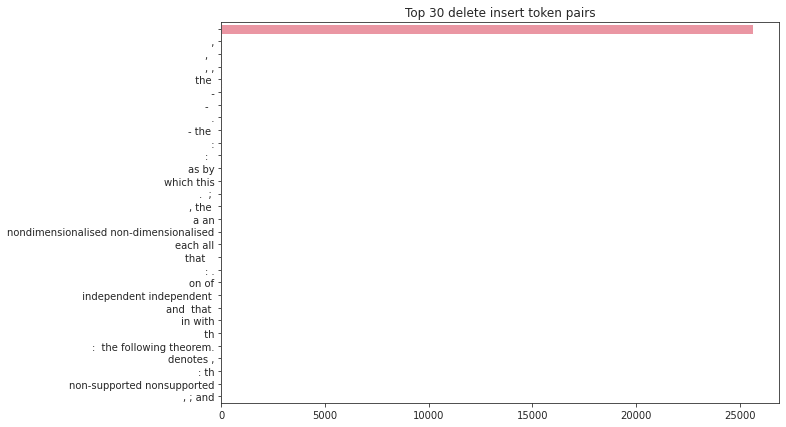

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('ticks')
plt.title('Top 30 delete insert token pairs')
sns.barplot(y=del_ins_pair_plt.index, x= del_ins_pair_plt.values )

In [ ]:
errpoints[['SBE','SAE','del_word','ins_word']]

,SBE,SAE,del_word,ins_word
233181,The inclusion of immune effectors reflects the...,The inclusion of immune effectors reflects the...,NaN,NaN
269482,"At present, the values of the pion polarisabil...","At present, the values of the pion polarisabil...",NaN,NaN
164312,The receipt should be kept in case of disputes.,The receipt should be kept in case of disputes.,NaN,NaN
17385,Our experimental results provide valuable insi...,Our experimental results provide valuable insi...,NaN,NaN
266075,It makes sense to abstract the definition of a...,It makes sense to abstract the definition of a...,NaN,NaN
...,...,...,...,...
281543,Being based on the whole posterior distributio...,Being based on the whole posterior distributio...,NaN,NaN
258201,Note that Tables _REF_ and _REF_ were computed...,Note that Tables _REF_ and _REF_ were computed...,NaN,NaN
183644,Theorems III-IV are then deduced from Theorems...,Theorems III-IV are then deduced from Theorems...,NaN,NaN
103358,"Specifically, the stimulation of ECs by VEGF l...","Specifically, the stimulation of ECs by VEGF l...",NaN,NaN


without the NaN values

In [ ]:
del_ins_pair = errpoints['del_word']+' '+errpoints['ins_word']

In [ ]:
del_ins_pair_plt = del_ins_pair.value_counts().sort_values(ascending = False).head(30)

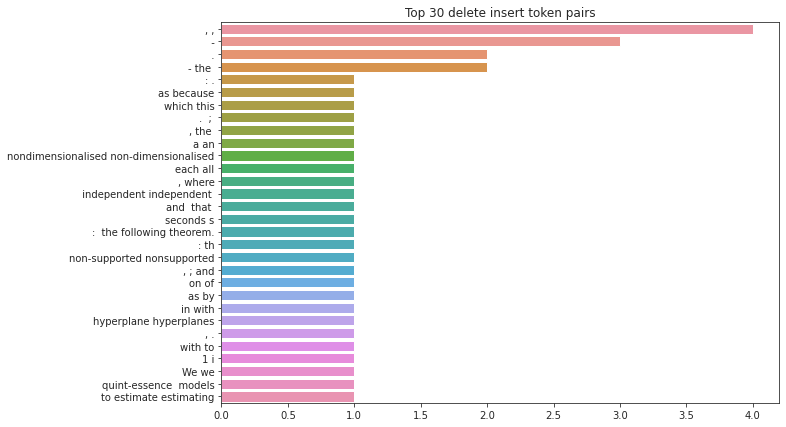

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('ticks')
plt.title('Top 30 delete insert token pairs')
sns.barplot(y=del_ins_pair_plt.index, x= del_ins_pair_plt.values )

In [ ]:
errpoints[errpoints['del_word'].notna() & errpoints['ins_word'].notna()][['SBE','SAE','del_word','ins_word']]

,SBE,SAE,del_word,ins_word
325349,If _MATH_ and _MATH_ with _MATH_ and _MATH_ in...,If _MATH_ and _MATH_ with independent _MATH_ a...,independent,independent
19647,"In the meantime, a sequence _MATH_ in _MATH_ i...","In the meantime, a sequence _MATH_ in _MATH_ i...",",",","
40844,We say that a sequence of admissible control _...,We say that a sequence of admissible controls ...,",",the
399847,"Since _MATH_ is unknown, we can use its estima...","Since _MATH_ is unknown, we can use its estima...",-,the
135282,This can be done as follows _MATHDISP_ with: _...,This can be done as follows: _MATHDISP_ with _...,:,th
376285,(1) If in particular _MATH_ is also a vector s...,(i) If in particular _MATH_ is also a vector s...,1,i
389796,() _MATH_; _MATH_. _MATH_; _MATH_. _MATH_; _MA...,"() _MATH_, _MATH_; _MATH_, _MATH_; _MATH_, _MA...",.,;
310585,We have the following result:,We have the following result.,:,.
293417,The operator _MATH_ is said to be _MATH_-posit...,The operator _MATH_ is said to be _MATH_-posit...,on,of
375346,Let the _MATH_ transfer matrix _MATH_ be parti...,Let the _MATH_ transfer matrix _MATH_ be parti...,in,with


#Conclusion

1. Distillbert Trained on 400k data points gave the best F1 score.
2. No of FP: 13811. No of Fn: 10845.
3. The data that belonged to  FP had the same dist of domain as that of whole Train Class but Physics. So FP are little dependent on domain.
4. FN's domain dist followed the Test class.
5. The deleted-then-inserted word pair for FP mostly had Punctuations pairs, followed by is-are,section-Section,n't-not pairs, and then articles(a,an,the) pairs that got falsely predicted as not needing editing.
6. The deleted-then-inserted word pair for TN mostly had Punctuations pairs that got Truley predicted as needing editing.
7. Binary crossentropy loss dist is highly right skewed.
8. till 90th percentile of loss is irregularly distributed.
9. Most errorenous points belong to FP, and so deleted-then-inserted word pair for it closely follows FP.
10. Least error points belong to TN+TP and so most of the deleted-then-inserted word pair are NaN and apart from NaN values it is a subset of TN(105 points out of 10845).